## 항해를 시작해보자  with 쇄빙선 (캡틴: 김유식 , 선원1:박경원 , 선원2: 서무일, 선원3: 김주현)
- 준비물 : 침 받침 (구매처: https://www.coupang.com/vp/products/5825886593?itemId=10066027631&vendorItemId=77348904016&q=%EC%95%84%EA%B8%B0+%EC%B9%A8%EB%B0%9B%EC%B9%A8&itemsCount=36&searchId=8a18e96efa02400085c42beaad886fdf&rank=4&isAddedCart=)
- 준비물 : 기저귀 (구매처 :https://www.coupang.com/vp/products/5392102150?itemId=8044676619&vendorItemId=75333280024&q=%EA%B8%B0%EC%A0%80%EA%B7%80&itemsCount=36&searchId=bbb33c0280364022a4adade31021048c&rank=7&isAddedCart=)
- 이 포스팅은 쿠팡 파트너스 활동의 일환으로, 이에 따른 일정액의 수수료를 제공받을 수 있습니다.



- 목차

    - 데이터 정보 확인
    - 전처리
    - 모델링
    - 하이퍼파라미터 설정
    - 난파선이 될 뻔한 기록
   

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
from sklearn import metrics
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import *
from pylab import *
import glob, re
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_Restaurant_Visitor Forecasting'
processed_data_path = os.getenv('HOME')+'/aiffel/kaggle_Restaurant_Visitor Forecasting/Processed_Data'



air_visit = pd.read_csv(data_dir + "/air_visit_data.csv")
air_store = pd.read_csv(data_dir + "/air_store_info.csv")
hpg_store = pd.read_csv(data_dir + "/hpg_store_info.csv")
air_reserve = pd.read_csv(data_dir + "/air_reserve.csv")
hpg_reserve = pd.read_csv(data_dir + "/hpg_reserve.csv")
holidays = pd.read_csv(data_dir + "/date_info.csv")
store_id = pd.read_csv(data_dir + "/store_id_relation.csv")
test= pd.read_csv(data_dir + "/sample_submission.csv")

In [3]:

air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [5]:
### visit_date,visitors 인덱스를 다 더해서 더하고 air_visit_visitors_PerDay에 담는다

In [6]:
air_visit_visitors_PerDay = pd.DataFrame(air_visit.groupby("visit_date")["visitors"].sum()).reset_index()
air_visit_visitors_PerDay.index +=1

In [7]:
air_visit_visitors_PerDay.head()

,visit_date,visitors
1,2016-01-01,1033
2,2016-01-02,1764
3,2016-01-03,2368
4,2016-01-04,3326
5,2016-01-05,3927


In [8]:
### visit_date를 판다스에 이용할 수 있게  pd.to_datetime 이용하고 도식화 시킨다

In [9]:

air_visit_visitors_PerDay["visit_date"]=pd.to_datetime(air_visit_visitors_PerDay["visit_date"])

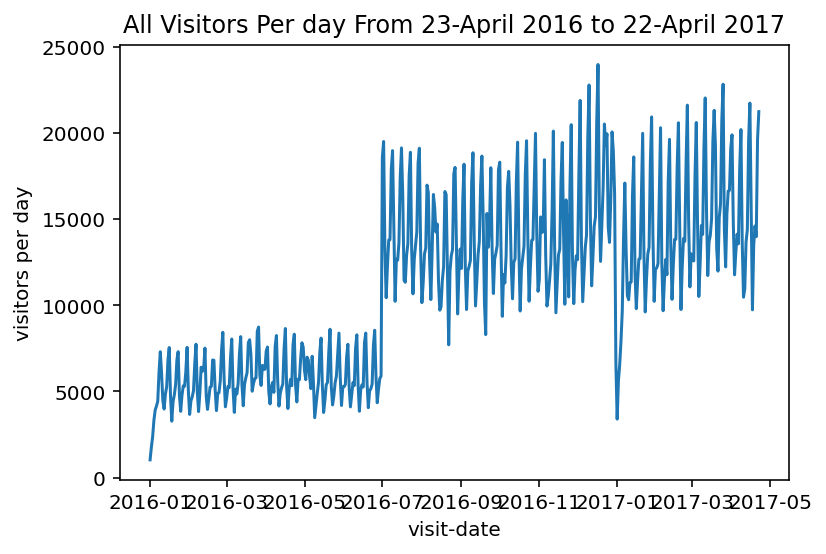

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(air_visit_visitors_PerDay["visit_date"],air_visit_visitors_PerDay["visitors"])

plt.xlabel("visit-date")
plt.ylabel("visitors per day")
plt.title("All Visitors Per day From 23-April 2016 to 22-April 2017")
plt.figure(figsize=(100,100))
plt.figure().subplots_adjust(bottom=0.2)
plt.show()

- 2016-6 월 ~ 12월까지 비교적 상승함을 알 수 있고, 2017-1월은 작년초와 동일하게 방문객이 갑작스럽게 떨어짐을 알 수 있다.

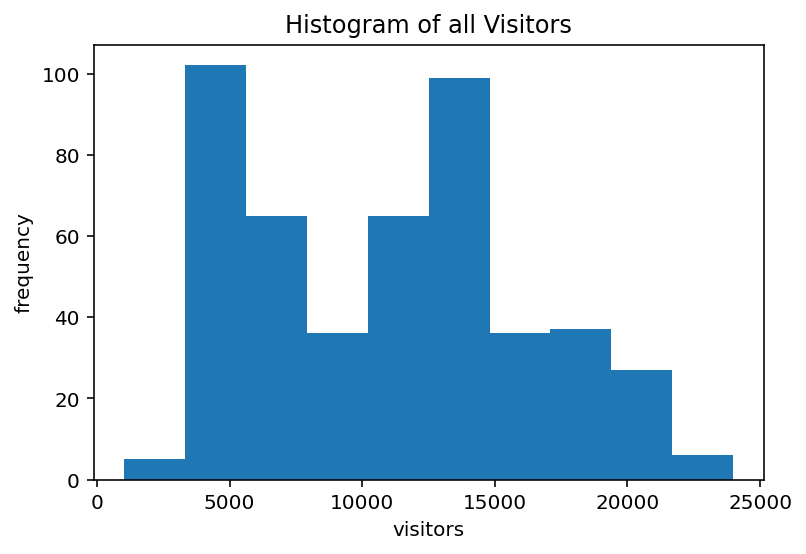

In [11]:
plt.hist(air_visit_visitors_PerDay["visitors"])
plt.xlabel("visitors")
plt.ylabel("frequency")
plt.title("Histogram of all Visitors")
plt.show()

- 방문객 수 의 빈도수를 알아보자 (5000~1500이하가 두드러짐)

### 기준에 따라 데이터를 그룹으로 분할하는 데 사용됩니다 . groupby() 이후에 인덱스를 재설정하기 위해 reset_index() 함수를 사용
- groupby의  median() 을 이용해서 값 목록을 정렬하고 중간 값을 찾는다
- 평일 주말 방문자 도식화

In [12]:

air_visit_visitors_PerDay["weekday"]=air_visit_visitors_PerDay["visit_date"].apply(lambda x: x.weekday())

b =pd.DataFrame({"week" : ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
"weekday" : [0,1,2,3,4,5,6]})
b.index +=1

In [13]:
air_visit_visitors_PerDay= air_visit_visitors_PerDay.merge(b,on="weekday")

In [14]:
x=pd.DataFrame(air_visit_visitors_PerDay.groupby("week")["visitors"].median()).reset_index()

In [15]:
# air_visit_visitors_PerDay

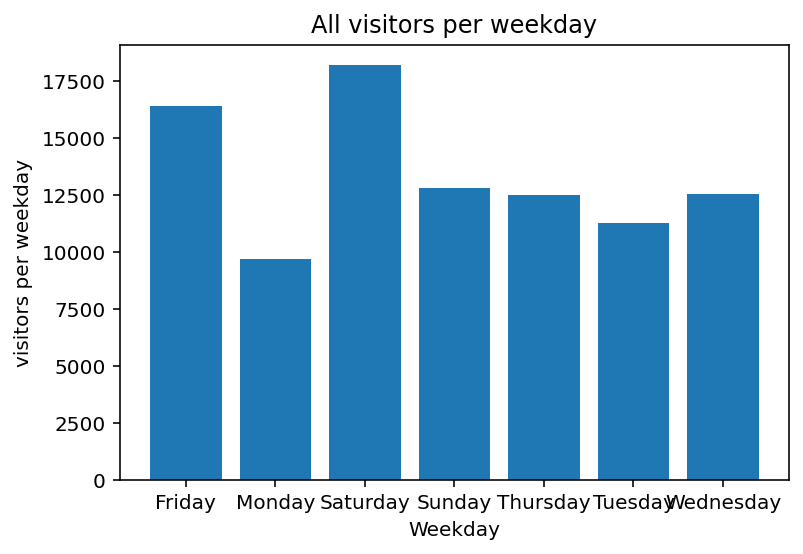

In [16]:
plt.bar(x["week"],x["visitors"])
plt.xlabel("Weekday")
plt.ylabel("visitors per weekday")
plt.title("All visitors per weekday")
plt.show()

- 토요일이 가장 많고 2번째 금요일 많으며 의외롤 일요일은 평일과 비슷한 수준의 방문자 수 알 수 있다

In [17]:
### 요일 도식화 코드와 비슷하게 진행되며 merge 함수를 이용해 요일데이터와 병합시킨다.

In [18]:
air_visit_visitors_PerDay["month"]=air_visit_visitors_PerDay["visit_date"].dt.month
c =pd.DataFrame({"Month" : ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
"month" : [1,2,3,4,5,6,7,8,9,10,11,12]})
c.index+=1
air_visit_visitors_PerDay = air_visit_visitors_PerDay.merge(c)

In [19]:
del air_visit_visitors_PerDay["month"]
del air_visit_visitors_PerDay["weekday"]

In [20]:
z=pd.DataFrame(air_visit_visitors_PerDay.groupby("Month")["visitors"].median()).reset_index()

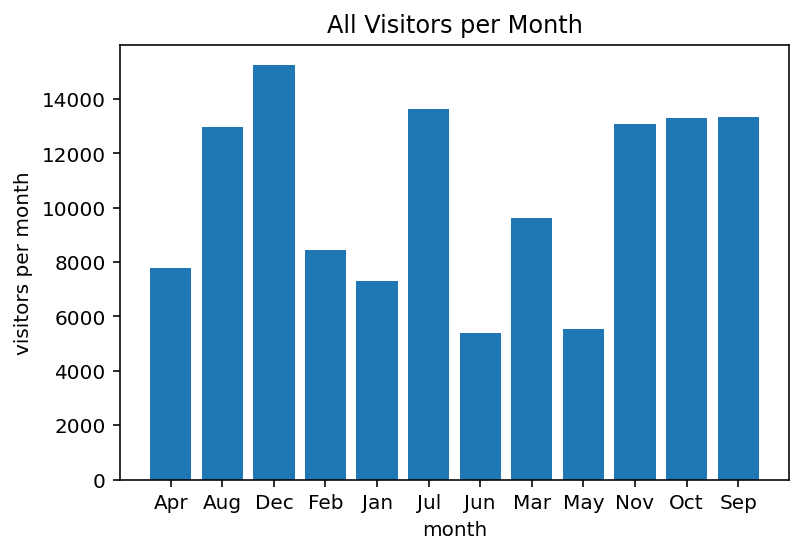

In [21]:
plt.bar(z["Month"],z["visitors"])
plt.xlabel("month")
plt.ylabel("visitors per month")
plt.title("All Visitors per Month")
plt.show()

- 12월이 가장 방문자 수 가 많으며 2번째로 7월 방문자가 많으며 , 5,6월이 가장 적다

In [22]:
### visit_date를 인덱스로 변환후 loc 를 이용해 날짜 들을 불러온다

In [23]:
air_visit_visitors_PerDay = air_visit_visitors_PerDay.set_index("visit_date")

In [24]:
req_df = air_visit_visitors_PerDay.loc["2016-04-23":"2016-05-31"]
req_df = req_df.reset_index(level=0)
req_df =req_df.sort_values(by="visit_date")

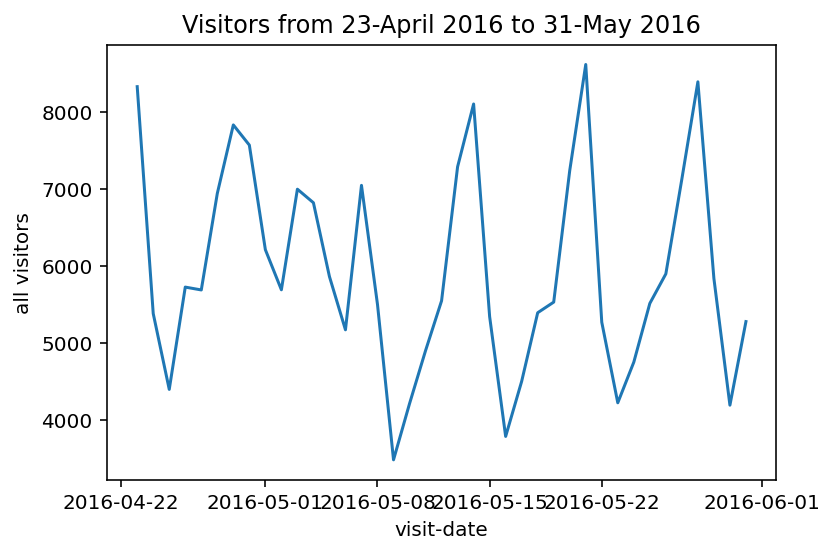

<Figure size 14400x14400 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(req_df["visit_date"],req_df["visitors"])
plt.xlabel("visit-date")
plt.ylabel("all visitors")
plt.title("Visitors from 23-April 2016 to 31-May 2016")
plt.figure(figsize=(200,200))

plt.figure().subplots_adjust(bottom=0.2)
plt.show()

- bar 형태에서 plot를 형태로 바꿔서 더 정확한 데이터를 파악해보자.
- 5,6월과 비슷하게 가장 낮은 수치를 봤지만 정확히 5월의 수치가 더 낮다는것을 알 수 있다.

### 결측치 확인

In [26]:
def check_null_values(df: pd.DataFrame):

    
    return np.any(df.isna().sum() > 1)


print("Null values check".center(50, "="))
print()
print("air_visit_data:", check_null_values(air_visit))
print("air_reservation_data:", check_null_values(air_reserve))
print("air_store_info:", check_null_values(air_store))
print("date_info:", check_null_values(holidays))
print("hpg_reservation_data:", check_null_values(hpg_reserve))
print("hpg_store_info:", check_null_values(hpg_store))
print("store_id_relation:", check_null_values(store_id))



================Null values check=================

air_visit_data: False
air_reservation_data: False
air_store_info: False
date_info: False
hpg_reservation_data: False
hpg_store_info: False
store_id_relation: False


- isna().sum()을 이용해 True,False 명제를 나오게 불러옴 False일 경우 결측치가 없음

## Air Reservations Data

In [27]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [28]:
### ('D').sum(). 부분적으로 작동하지만 일부 인덱스 날짜(원시 파일에 누락된 데이터 없음)는 NaN을 반환

In [29]:
air_reserve["visit_datetime"] = pd.to_datetime(air_reserve["visit_datetime"])

In [30]:
data = air_reserve[["visit_datetime","reserve_visitors"]]

In [31]:
data = data.set_index("visit_datetime").resample("D").sum() 

In [32]:
data= data.reset_index()

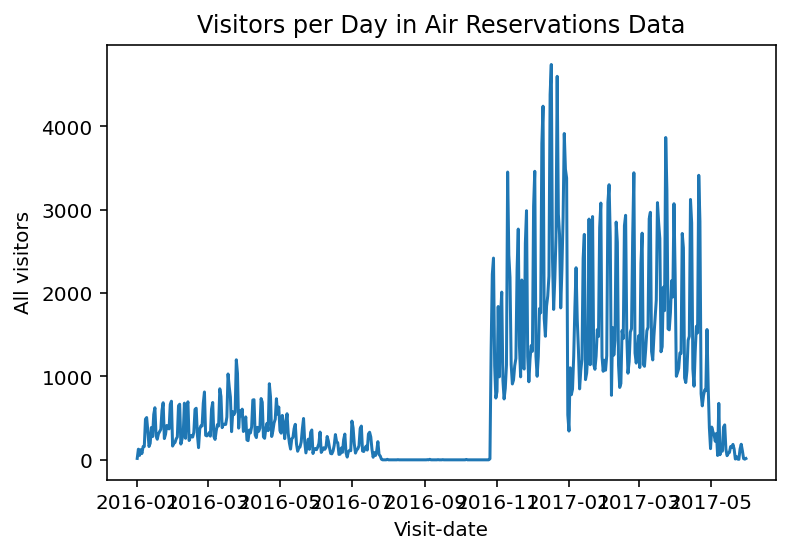

<Figure size 7200x7200 with 0 Axes>

In [33]:
plt.plot(data["visit_datetime"],data["reserve_visitors"])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in Air Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

- Air Reservations 데이터의 방문자수 도식화

In [34]:
## Air Reservations Data에 대한 시간별 방문자수 확인 가능

In [35]:
air_reserve_1 = air_reserve[["visit_datetime","reserve_visitors"]]

In [36]:
air_reserve_1["visit_hour"] =  air_reserve_1.visit_datetime.dt.hour

In [37]:
air_reserve_1.head()

,visit_datetime,reserve_visitors,visit_hour
0,2016-01-01 19:00:00,1,19
1,2016-01-01 19:00:00,3,19
2,2016-01-01 19:00:00,6,19
3,2016-01-01 20:00:00,2,20
4,2016-01-01 20:00:00,5,20


In [38]:
air_reserve_1_req = pd.DataFrame(air_reserve_1.groupby("visit_hour")["reserve_visitors"].sum())

In [39]:
air_reserve_1_req = air_reserve_1_req.reset_index()

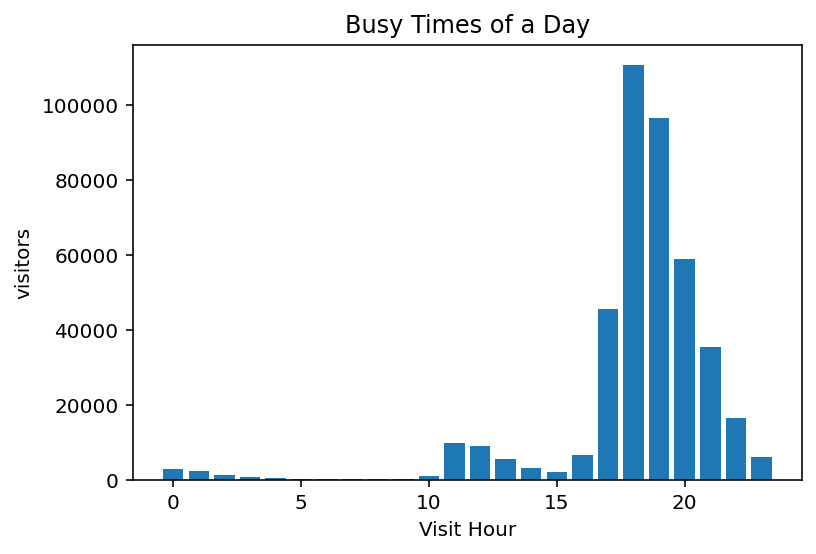

In [40]:
plt.bar(air_reserve_1_req["visit_hour"],air_reserve_1_req["reserve_visitors"])
plt.xlabel("Visit Hour")
plt.ylabel("visitors")
plt.title("Busy Times of a Day")
plt.show()

In [41]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [42]:
air_reserve["reserve_datetime"]=pd.to_datetime(air_reserve["reserve_datetime"])

In [43]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      92378 non-null  object        
 1   visit_datetime    92378 non-null  datetime64[ns]
 2   reserve_datetime  92378 non-null  datetime64[ns]
 3   reserve_visitors  92378 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


In [44]:
air_reserve["timeDiff"]=(air_reserve["visit_datetime"]-air_reserve["reserve_datetime"]).astype('timedelta64[h]')

In [45]:
air_reserve["days"] = air_reserve["timeDiff"]/24

### 모든 사람들이 가까운 미래에 예약이 아니라 1년 이상의 예약자도 있다는 것을 간과 하지말자!
- 1년 이상의 예약하고 방문하는 인원이 적지 않다. ( ex 기념일,행사 등으로 유추해 볼 수 있다.)

In [46]:
air_reserve[air_reserve["days"] > 365]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days
50772,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-14 23:00:00,2,8877.0,369.875000
50773,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-15 13:00:00,3,8863.0,369.291667
50774,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-03 12:00:00,4,9152.0,381.333333
50797,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-18 08:00:00,2,8796.0,366.500000
50799,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-17 18:00:00,2,8810.0,367.083333
50805,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 20:00:00,2,9168.0,382.000000
50806,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-06 17:00:00,20,9075.0,378.125000
50809,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 21:00:00,6,9167.0,381.958333
50813,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-05 16:00:00,2,9100.0,379.166667
50826,air_2a485b92210c98b5,2017-01-18 20:00:00,2016-01-02 00:00:00,4,9188.0,382.833333


### HPG Reserve data
- air 와 비교해서 알아보자

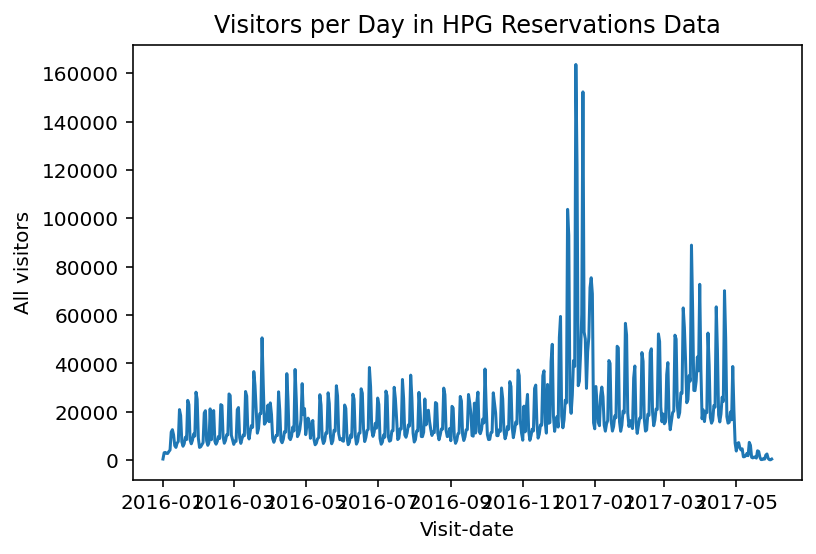

<Figure size 7200x7200 with 0 Axes>

In [47]:
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
data_2 = hpg_reserve[["visit_datetime","reserve_visitors"]]
data_2 = data_2.set_index("visit_datetime").resample("D").sum()
data_2= data_2.reset_index()
plt.plot(data_2["visit_datetime"],data_2["reserve_visitors"])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in HPG Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

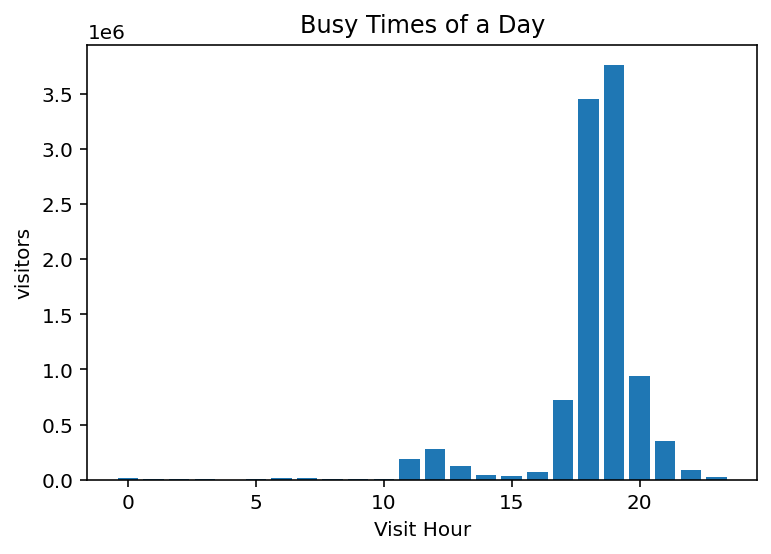

In [48]:
hpg_reserve_1 = hpg_reserve[["visit_datetime","reserve_visitors"]]
hpg_reserve_1["visit_hour"] =  hpg_reserve_1.visit_datetime.dt.hour
hpg_reserve_1_req = pd.DataFrame(hpg_reserve_1.groupby("visit_hour")["reserve_visitors"].sum())
hpg_reserve_1_req = hpg_reserve_1_req.reset_index()
plt.bar(hpg_reserve_1_req["visit_hour"],hpg_reserve_1_req["reserve_visitors"])
plt.xlabel("Visit Hour")
plt.ylabel("visitors")
plt.title("Busy Times of a Day")
plt.show()

In [49]:
hpg_reserve["reserve_datetime"]=pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["timeDiff"]=(hpg_reserve["visit_datetime"]-hpg_reserve["reserve_datetime"]).astype('timedelta64[h]')
hpg_reserve["days"] = hpg_reserve["timeDiff"]/24
hpg_reserve[hpg_reserve["days"] > 360]

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days
1605287,hpg_27220c59393af3ff,2017-02-23 19:00:00,2016-02-21 16:00:00,2,8835.0,368.125
1847912,hpg_f1e9bb84d62ac5e6,2017-04-01 19:00:00,2016-04-04 19:00:00,5,8688.0,362.000


### Air Store Data

In [50]:
air_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [51]:
air_store_genreWise = pd.DataFrame(air_store.groupby("air_genre_name")["air_store_id"].count()).reset_index()
air_store_genreWise.index+=1
air_store_genreWise = air_store_genreWise.rename(columns={"air_store_id":"noOfRest"})
air_store_genreWise = air_store_genreWise.sort_values(by="noOfRest",ascending=False)


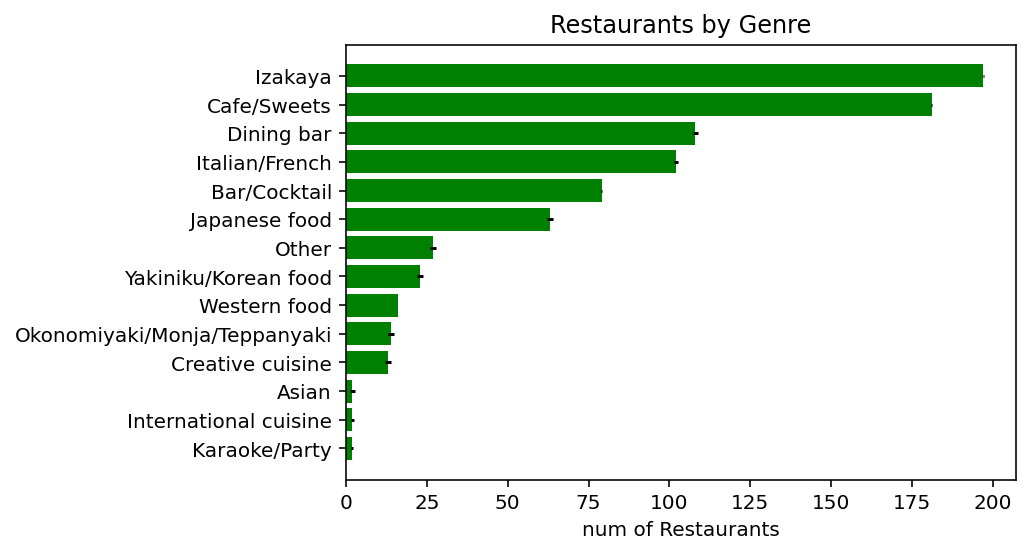

In [52]:

fig, ax = plt.subplots()
error = np.random.rand(len(air_store_genreWise["air_genre_name"]))
y_pos = np.arange(len(air_store_genreWise["air_genre_name"]))
ax.barh(y_pos, air_store_genreWise["noOfRest"], xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(air_store_genreWise["air_genre_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Genre')

plt.show()


In [53]:
air_store_areaWise = pd.DataFrame(air_store.groupby("air_area_name")["air_store_id"].count()).reset_index()
air_store_areaWise.index+=1
air_store_areaWise = air_store_areaWise.rename(columns={"air_store_id":"noOfRest"})
air_store_areaWise=air_store_areaWise.sort_values(by="noOfRest",ascending=False)[:16]

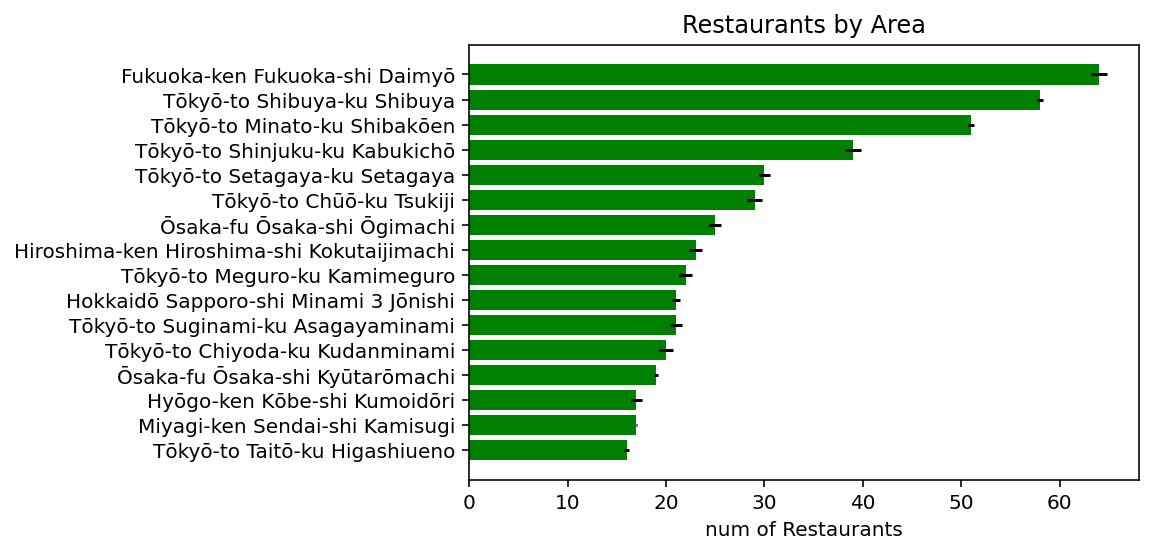

In [54]:
fig, ax = plt.subplots()
error2 = np.random.rand(len(air_store_areaWise["air_area_name"]))
y_pos2 = np.arange(len(air_store_areaWise["air_area_name"]))
ax.barh(y_pos2, air_store_areaWise["noOfRest"], xerr=error2, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos2)
ax.set_yticklabels(air_store_areaWise["air_area_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Area')

plt.show()

- 아무래도 일본스럽게 이자캬야(선술집)이 많다
- 왜 인구 밀도에 비해 top1 이 후쿠오카일까?
- 후쿠오카 다이묘 : 새롭게 신도시로 급부상 하기 때문에 신점된 식당마다  air 포스기 도입이 많은것으로 유추할 수 있다.

In [55]:

hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


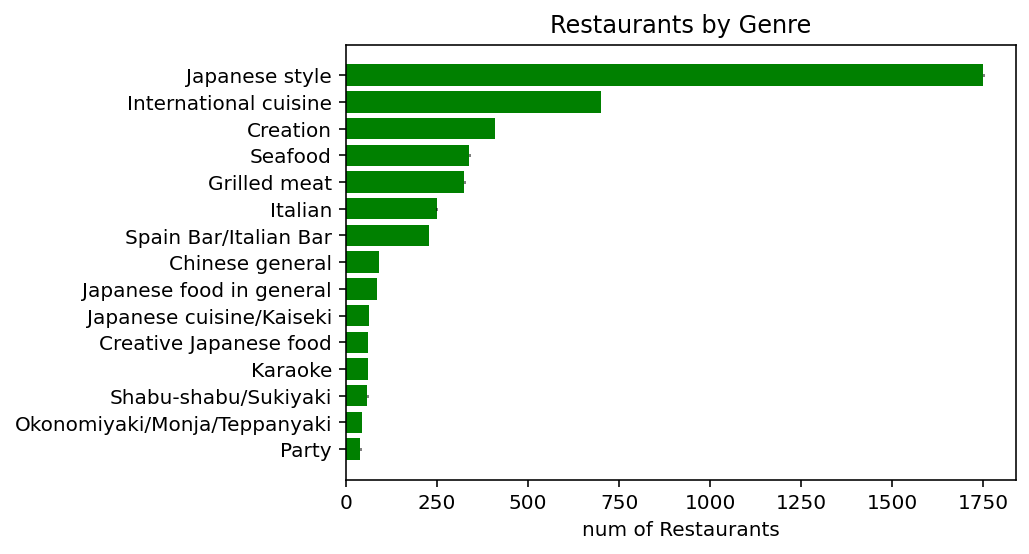

In [56]:

hpg_store_genreWise = pd.DataFrame(hpg_store.groupby("hpg_genre_name")["hpg_store_id"].count()).reset_index()
hpg_store_genreWise.index+=1
hpg_store_genreWise = hpg_store_genreWise.rename(columns={"hpg_store_id":"noOfRest"})
hpg_store_genreWise = hpg_store_genreWise.sort_values(by="noOfRest",ascending=False)[:15]
fig, ax = plt.subplots()
error = np.random.rand(len(hpg_store_genreWise["hpg_genre_name"]))
y_pos = np.arange(len(hpg_store_genreWise["hpg_genre_name"]))
ax.barh(y_pos, hpg_store_genreWise["noOfRest"], xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(hpg_store_genreWise["hpg_genre_name"])
ax.invert_yaxis()  # 위에서 아래로 읽는다.
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Genre')

plt.show()

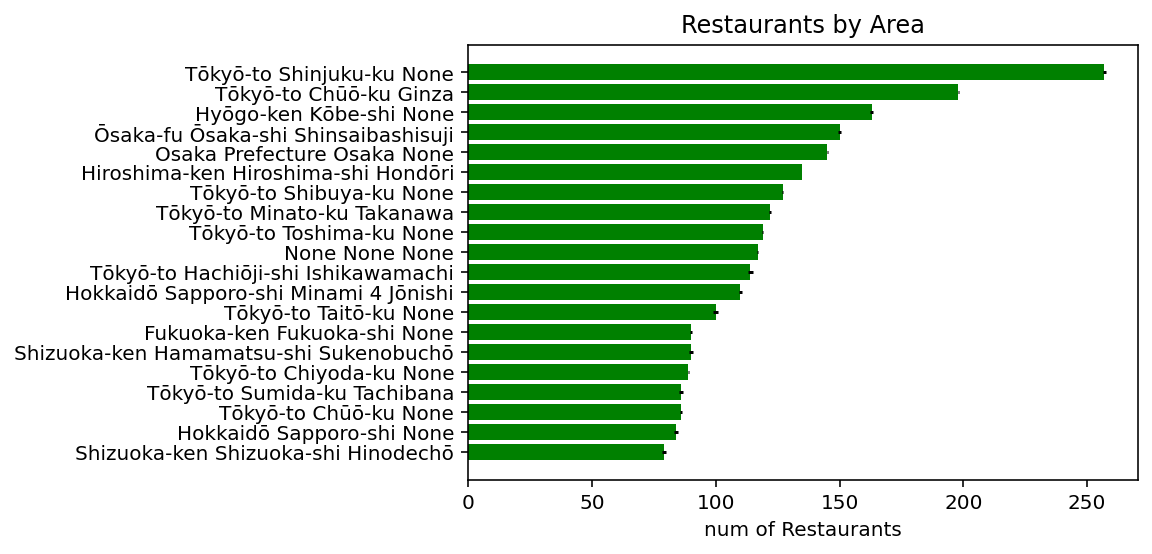

In [57]:

hpg_store_areaWise = pd.DataFrame(hpg_store.groupby("hpg_area_name")["hpg_store_id"].count()).reset_index()
hpg_store_areaWise.index+=1
hpg_store_areaWise = hpg_store_areaWise.rename(columns={"hpg_store_id":"noOfRest"})
hpg_store_areaWise=hpg_store_areaWise.sort_values(by="noOfRest",ascending=False)[:20]
fig, ax = plt.subplots()
error2 = np.random.rand(len(hpg_store_areaWise["hpg_area_name"]))
y_pos2 = np.arange(len(hpg_store_areaWise["hpg_area_name"]))
ax.barh(y_pos2, hpg_store_areaWise["noOfRest"], xerr=error2, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos2)
ax.set_yticklabels(hpg_store_areaWise["hpg_area_name"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('num of Restaurants')
ax.set_title('Restaurants by Area')

plt.show()

- 2016년기준 도쿄가 가장많은 인구를 차지 하고 있다. 2위 요코하마와 2배이상 hpg는 인구의 비례하는 데이터 유추가 가능하다


### 데이터 변환

In [58]:
hpg_reserve = pd.merge(hpg_reserve, store_id, how='inner', on=['hpg_store_id'])

In [59]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,timeDiff,days,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,4.0,0.166667,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,5.0,0.208333,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,22.0,0.916667,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,46.0,1.916667,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,4.0,0.166667,air_db80363d35f10926


- datetime으로 변환하고, 예약과 방문 사이의 일수를 알아내고, 모든 상점 id와 방문 데이터에 대한 diff의 합계로 구성된 데이터 프레임 t1을 생성하고 모든 air에 대한 평균 일수 diff와 방문자 diff로 구성된 데이터 프레임 t2를 생성. 상점 ID와 방문 날짜 및 t1 및 t2 결합
#### air 에 대한
- rs1 은 방문시간 - 방문예약시간 = gap(sum)
- rv1 은 예약방문자 수
- rs2 은 방문시간 - 방문예약시간 = gap(mean)
- rv2 은 예약방문자 수

In [60]:

air_reserve["visit_datetime"]= pd.to_datetime(air_reserve["visit_datetime"])
air_reserve["visit_datetime"] = air_reserve["visit_datetime"].dt.date
air_reserve["reserve_datetime"]= pd.to_datetime(air_reserve["reserve_datetime"])
air_reserve["reserve_datetime"] = air_reserve["reserve_datetime"].dt.date
air_reserve["reserve_datetime_diff"]= air_reserve.apply(lambda r: (r["visit_datetime"]-r["reserve_datetime"]).days,axis=1)
t1 = air_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].sum().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs1","reserve_visitors":"rv1"})
t2 = air_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].mean().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs2","reserve_visitors":"rv2"})
air_reserve = pd.merge(t1,t2,how="inner",on=["air_store_id","visit_date"])

In [61]:
air_reserve.head()

,air_store_id,visit_date,rs1,rv1,rs2,rv2
0,air_00a91d42b08b08d9,2016-10-31,0,2,0.0,2.0
1,air_00a91d42b08b08d9,2016-12-05,4,9,4.0,9.0
2,air_00a91d42b08b08d9,2016-12-14,6,18,6.0,18.0
3,air_00a91d42b08b08d9,2016-12-17,6,2,6.0,2.0
4,air_00a91d42b08b08d9,2016-12-20,2,4,2.0,4.0


#### hpg 에 대한
- rs1 은 방문시간 - 방문예약시간 = gap(sum)
- rv1 은 예약방문자 수
- rs2 은 방문시간 - 방문예약시간 = gap(mean)
- rv2 은 예약방문자 수
- 방문객들의 최소,중간값,중앙값,최대값,빈도 수 를 뽑아냈다.

In [62]:
hpg_reserve["visit_datetime"]= pd.to_datetime(hpg_reserve["visit_datetime"])
hpg_reserve["visit_datetime"] = hpg_reserve["visit_datetime"].dt.date
hpg_reserve["reserve_datetime"]= pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["reserve_datetime"] = hpg_reserve["reserve_datetime"].dt.date
hpg_reserve["reserve_datetime_diff"]= hpg_reserve.apply(lambda r: (r["visit_datetime"]-r["reserve_datetime"]).days,axis=1)
t11 = hpg_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].sum().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs1","reserve_visitors":"rv1"})
t22 = hpg_reserve.groupby(["air_store_id","visit_datetime"],as_index=False)[["reserve_datetime_diff","reserve_visitors"]].mean().rename(columns={"visit_datetime":"visit_date","reserve_datetime_diff":"rs2","reserve_visitors":"rv2"})
hpg_reserve = pd.merge(t11,t22,how="inner",on=["air_store_id","visit_date"])

In [63]:
air_visit_1 = pd.read_csv("air_visit_data.csv")

In [64]:
air_visit_1["visit_date"] = pd.to_datetime(air_visit_1["visit_date"])
air_visit_1['DayofWeek'] = air_visit_1['visit_date'].dt.dayofweek
air_visit_1['year'] = air_visit_1['visit_date'].dt.year
air_visit_1['month'] = air_visit_1['visit_date'].dt.month
air_visit_1['visit_date'] = air_visit_1['visit_date'].dt.date

In [65]:
test["visit_date"]=test["id"].map(lambda x: str(x).split("_")[2])
test["air_store_id"]=test["id"].map(lambda x: "_".join(x.split("_")[:2]))
test["visit_date"] = pd.to_datetime(test["visit_date"])
test["DayofWeek"] = test["visit_date"].dt.dayofweek
test["year"] = test["visit_date"].dt.year
test["month"] = test["visit_date"].dt.month
test["visit_date"] = test["visit_date"].dt.date

In [66]:
distinct_stores=test["air_store_id"].unique()
stores=pd.concat([pd.DataFrame({"air_store_id":distinct_stores,"DayofWeek":[i]*len(distinct_stores)}) for i in range(7)],axis=0,ignore_index=True).reset_index(drop=True)

In [67]:
t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].min().rename(columns={"visitors":"min_visitors"})
stores=pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].mean().rename(columns={"visitors":"mean_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].median().rename(columns={"visitors":"median_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].max().rename(columns={"visitors":"max_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

t = air_visit_1.groupby(["air_store_id","DayofWeek"],as_index=False)["visitors"].count().rename(columns={"visitors":"count_visitors"})
stores= pd.merge(stores,t,how="left",on=["air_store_id","DayofWeek"])

k2 = air_visit_1.groupby(["air_store_id"]).agg({"visitors":[np.mean,np.std]}).reset_index()
k2.columns=["air_store_id","mean_visitorso","std_devo"]
stores=pd.merge(stores,k2,how="left",on=["air_store_id"])
stores=pd.merge(stores,air_store,how="left",on=["air_store_id"])

## New Features

- stores의 데이터 특징들을 뽑아내어  train,test의 라벨들을 저장함

In [68]:
stores.head()

,air_store_id,DayofWeek,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


In [69]:
# 데이터 정제 ( -,/)
stores["air_genre_name"]=stores["air_genre_name"].map(lambda x: str(str(x).replace("/"," ")))
stores["air_area_name"]= stores["air_area_name"].map(lambda x: str(str(x).replace("-"," ")))
labelEncode = preprocessing.LabelEncoder()  # 숫자가 아닌 레이블을 숫자 레이블로 변환하는 데에도 사용할 수 있습니다.

In [70]:
stores.head()

,air_store_id,DayofWeek,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,Italian French,Tōkyō to Chiyoda ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,Italian French,Tōkyō to Minato ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,Izakaya,Tōkyō to Taitō ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,Dining bar,Ōsaka fu Ōsaka shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,Cafe Sweets,Ōsaka fu Ōsaka shi Ōhiraki,34.692337,135.472229


In [71]:
for i in range(10):
    stores["air_genre_name"+str(i)] = labelEncode.fit_transform(stores["air_genre_name"].map(lambda x: str(str(x).split(" ")[i]) if len(str(x).split(" ")) >i else ""))
    stores["air_area_name"+str(i)] = labelEncode.fit_transform(stores["air_area_name"].map(lambda x: str(str(x).split(" ")[i]) if len(str(x).split(" ")) >i else ""))
stores["air_genre_name"] = labelEncode.fit_transform(stores["air_genre_name"])
stores["air_area_name"] = labelEncode.fit_transform(stores["air_area_name"])
stores['area']=stores['air_area_name'].map(lambda x: str(str(x).split(' ')[:2]))
stores['area']=labelEncode.fit_transform(stores['area'])
stores['area']=stores['air_area_name'].map(lambda x: str(str(x).split(' ')[:2]))
stores['area']=labelEncode.fit_transform(stores['area'])

In [72]:
stores.head()

,air_store_id,DayofWeek,min_visitors,mean_visitors,median_visitors,max_visitors,count_visitors,mean_visitorso,std_devo,air_genre_name,...,air_area_name5,air_genre_name6,air_area_name6,air_genre_name7,air_area_name7,air_genre_name8,air_area_name8,air_genre_name9,air_area_name9,area
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,26.081897,12.435364,6,...,0,0,0,0,0,0,0,0,0,42
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,9.248322,6.348980,6,...,0,0,0,0,0,0,0,0,0,62
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,9.896465,6.214877,7,...,0,0,0,0,0,0,0,0,0,84
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,7.939655,6.733807,4,...,0,0,0,0,0,0,0,0,0,101
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,14.828685,13.154107,2,...,0,0,0,0,0,0,0,0,0,5


In [73]:
# to_datetime 계산할 수 있는 pandas식으로 바꿈
holidays = holidays.rename(columns={"calendar_date":"visit_date"})
holidays["visit_date"] = pd.to_datetime(holidays["visit_date"])
holidays["day_of_week"] = labelEncode.fit_transform(holidays["day_of_week"])
holidays["visit_date"] = holidays["visit_date"].dt.date

In [74]:
train = pd.merge(air_visit_1,holidays,how="left",on=["visit_date"])
test = pd.merge(test,holidays,how="left",on=["visit_date"])

train = pd.merge(train,stores,how="left",on=["air_store_id","DayofWeek"])
test = pd.merge(test,stores,how="left",on=["air_store_id","DayofWeek"])

In [75]:

for df in [air_reserve,hpg_reserve]:
    train = pd.merge(train, df, how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, df, how='left', on=["air_store_id","visit_date"])

In [76]:
test.head()

,id,visitors,visit_date,air_store_id,DayofWeek,year,month,day_of_week,holiday_flg,min_visitors,...,air_area_name9,area,rs1_x,rv1_x,rs2_x,rv2_x,rs1_y,rv1_y,rs2_y,rv2_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,...,0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
train["id"] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

In [78]:
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [79]:
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [80]:
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [81]:

test.head()

,id,visitors,visit_date,air_store_id,DayofWeek,year,month,day_of_week,holiday_flg,min_visitors,...,rs1_y,rv1_y,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170423,8.326629,4.519803
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170424,8.326629,4.519803
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170425,8.326629,4.519803
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170426,8.326629,4.519803
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170427,8.326629,4.519803


In [82]:

train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']


train['air_store_id2'] = labelEncode.fit_transform(train['air_store_id'])
test['air_store_id2'] = labelEncode.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

### GridSearch 를 통해 파라미터를 설정해보자

In [83]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### XGBRegressor
- 2회 돌려보았다. (한번 돌리는데 너무 많은 시간이 소요;;)
- 적당한 n_estimators, max_depth 값은 1, 200 일때 RMSLE이 가장적게 출력됨

In [84]:

#param_grid = {
#    'n_estimators': [50, 100,200],  # n_estimators,max_depth 에서 Rmse을 보고 판단
#    'max_depth': [1, 10,12],
#}
#model = XGBRegressor(random_state=3) # 1로 두면 random으로 10
#my_GridSearch(model, train[col], train['visitors'].values, param_grid, verbose=2, n_jobs=5)

In [85]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [86]:
model3= XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8,colsample_bytree=0.8, max_depth =1,n_jobs=-1)

In [87]:
model3.fit(train[col], np.log1p(train['visitors'].values))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=3,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### LGBMRegressor 
- max_depth,n_estimators: 10,200 = 10.75
- max_depth,n_estimators: 70,400 = 10.79
- max_depth,n_estimators: 6,160 = 10.74
- max_depth,n_estimators: 4,160 = 10.73

- 의외의 결과이다 : max_depth,n_estimators 적게 지정할 수록 RMSLE이가 낮아짐

In [89]:
param_grid = {
    'n_estimators': [120,140,160],
    'max_depth': [2,4,6],
}
model = LGBMRegressor(random_state=3)
my_GridSearch(model, train[col], train['visitors'].values, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   34.5s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:   49.1s finished


,max_depth,n_estimators,score,RMSLE
5,4,160,-115.173637,10.731898
4,4,140,-115.208442,10.733520
3,4,120,-115.296923,10.737640
6,6,120,-115.302632,10.737906
7,6,140,-115.382056,10.741604
8,6,160,-115.403492,10.742602
2,2,160,-116.794615,10.807156
1,2,140,-117.049315,10.818933
0,2,120,-117.341587,10.832432


In [90]:
model1 = LGBMRegressor(learning_rate=0.1, max_depth=4, n_estimators=160,num_leaves=15, random_state=3)

# grid_model = GridSearchCV(model, param_grid=param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)

model1.fit(train[col], np.log1p(train['visitors'].values))


LGBMRegressor(max_depth=4, n_estimators=160, num_leaves=15, random_state=3)

### KNeighborsRegressor (k회귀)
- n_neighbors=4 했을때 가장 낮은 값 출력 확인

In [91]:
model2= neighbors.KNeighborsRegressor(n_jobs=-1,n_neighbors=4)

In [92]:
model2.fit(train[col], np.log1p(train['visitors'].values))


KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

In [93]:
predictions1 = model1.predict(train[col])
predictions2 = model2.predict(train[col])
predictions3 = model3.predict(train[col])

In [94]:
print('RMSE LGBMRegressor: ', RMSLE(np.log1p(train['visitors'].values), predictions1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), predictions2)) #0.419
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), predictions3))

RMSE LGBMRegressor:  0.4971791979801909
RMSE KNeighborsRegressor:  0.4196516109547516
RMSE XGBRegressor:  0.5135742003980435


In [95]:
test_preds1 = model1.predict(test[col])   # LGBMRegressor
test_preds2 = model2.predict(test[col])   # KNeighborsRegressor
test_preds3 = model3.predict(test[col])   # RMSE XGBRegressor

### 앙상블 진행

- 비중: 0.4* KNeighborsRegressor + 0.6 *RMSE XGBRegressor     = 0.48254
- 비중: 0.4 * KNeighborsRegressor + 0.6 * LGBMRegressor       = 0.48738
- 비중: 0.7 * KNeighborsRegressor + 0.2 * LGBMRegressor + 0.1 *RMSE XGBRegressor       = 0.4888
- 비중: 0.7 * KNeighborsRegressor + 0.2 * LGBMRegressor + 0.1 *RMSE XGBRegressor  = 0.51381
- 비중: 0.4 * KNeighborsRegressor + 0.1 * LGBMRegressor + 0.5 *RMSE XGBRegressor  = 0.48922

#### 앙상블 조합이라고 해서 RMSE가 낮은 거를 비중으로 두었을 경우를 관점으로 진행을 하였지만 원하는 점수를 얻지 못하였다.
- 오히려 가장 높은 RMS점수 XGBRegressord의 비중을 높였을 경우 더 높은 점수가 도출됌
- 앙상블 말그대로 진짜 조합을 찾아가는 방식으로 유추할 수 있다.

In [96]:
 test['visitors'] = 0.4*test_preds2+0.6*test_preds3   # 이때 가장 낮은 점수 반환
# test['visitors'] = 0.4*test_preds2+0.6*test_preds1   
#test['visitors'] = 0.7*test_preds2+0.2*test_preds1 + 0.1*test_preds3 
#test['visitors'] = 0.3*test_preds2+0.3*test_preds1 + 0.3*test_preds3 
#test['visitors'] = 0.4*test_preds2+0.1*test_preds1 + 0.5*test_preds3
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()

In [97]:
date_info = pd.read_csv("date_info.csv")
visit_data=pd.read_csv("air_visit_data.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [98]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### 규격을 맞추기 위해서 (data)

In [99]:

wkend_holidays = date_info.apply((lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True)

In [100]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')

In [101]:

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'),how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), on='air_store_id', how='left')['visitors_y'].values

In [102]:

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

In [103]:
sub_merge['visitors'] = 0.6*sub_merge['visitors_x'] + 0.4*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('submission3.csv', index=False)

## 위태로운 항해 
## 우리가 난파선이 될 뻔한 추억  

- 가장 가까운 역에서 주어진 거리에 몇 개의 상점(고유한 좌표에서)이 있는지에 대한 명확한 데이터를 시각화하여 방문객 수 를 예측하려고 하였음

In [104]:

# recruit-restaurant-visitor-forecasting
# 날씨 데이터 디렉토리가 압축되어 있기 때문에 다음과 같이 찾을 수 있습니다.:

sns.set_style('whitegrid')

# Because the weather data directory is compressed, you can find it like this:
weather_dir = os.getenv('HOME')+'/aiffel/kaggle_Restaurant_Visitor Forecasting/rrv-weather-data'

print('##### ../input/ Contents:')


print('\n##### {} Contents:'.format(weather_dir))

# Note that the contents of the below dir consist of another dir of the same name  
print('\n##### {} Contents:'.format('{}/1-1-16_5-31-17_Weather'.format(weather_dir)))

print('\n##### {} Contents:'.format('{}/1-1-16_5-31-17_Weather/1-1-16_5-31-17_Weather'.format(weather_dir)))

##### ../input/ Contents:

##### /aiffel/aiffel/kaggle_Restaurant_Visitor Forecasting/rrv-weather-data Contents:

##### /aiffel/aiffel/kaggle_Restaurant_Visitor Forecasting/rrv-weather-data/1-1-16_5-31-17_Weather Contents:

##### /aiffel/aiffel/kaggle_Restaurant_Visitor Forecasting/rrv-weather-data/1-1-16_5-31-17_Weather/1-1-16_5-31-17_Weather Contents:


In [105]:
# air_store_info = pd.read_csv('{}/air_store_info_with_nearest_active_station.csv', index_col=False)
air_store_info = pd.read_csv('{}/air_store_info_with_nearest_active_station.csv'.format(weather_dir))
# hpg_store_info = pd.read_csv('../input/rrv-weather-data/hpg_store_info_with_nearest_active_station.csv', index_col=False)
hpg_store_info = pd.read_csv('{}/hpg_store_info_with_nearest_active_station.csv'.format(weather_dir))

air_store_info['coordinate_count'] = air_store_info.groupby(
    ['latitude', 'longitude']
).latitude.transform('count').astype(int)
hpg_store_info['coordinate_count'] = hpg_store_info.groupby(
    ['latitude', 'longitude']
).latitude.transform('count').astype(int)

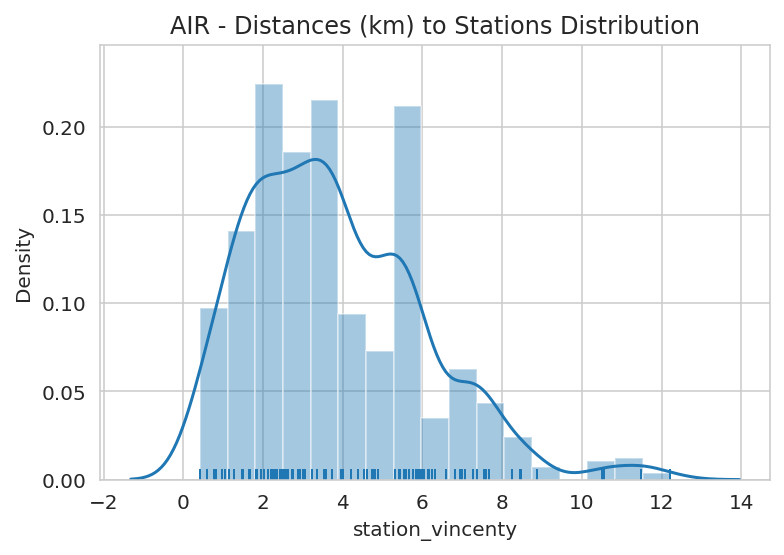

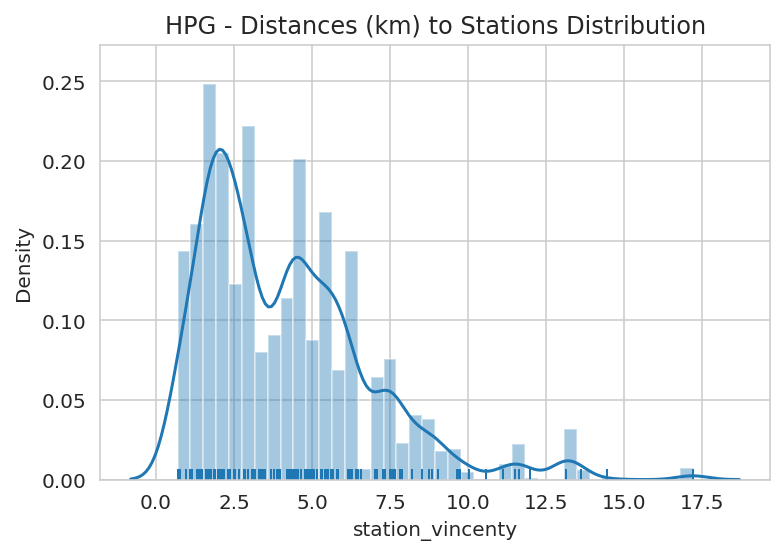

In [106]:
sns.distplot(air_store_info['station_vincenty'], rug=True, kde=True)
plt.title('AIR - Distances (km) to Stations Distribution')
plt.show()

# NOTE: This one might take a minute to show up
sns.distplot(hpg_store_info['station_vincenty'], rug=True, kde=True)
plt.title('HPG - Distances (km) to Stations Distribution')
plt.show()

In [107]:
###  hpg,air의 역 기준으로 거리 분포도를 확인해보자

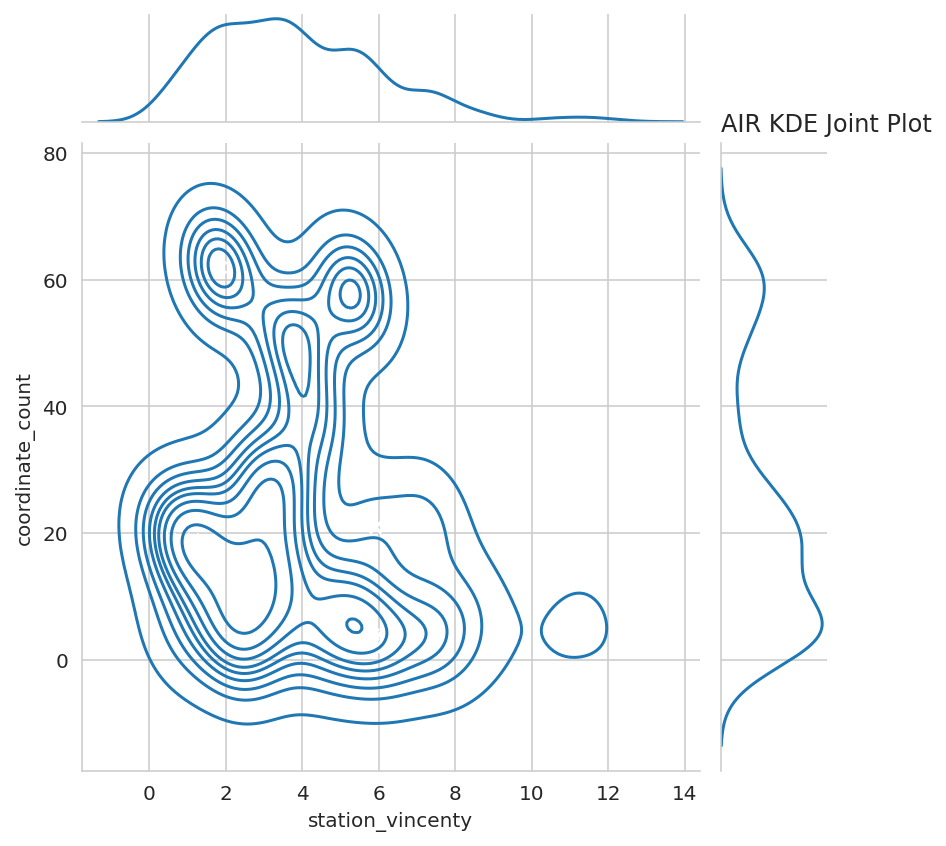

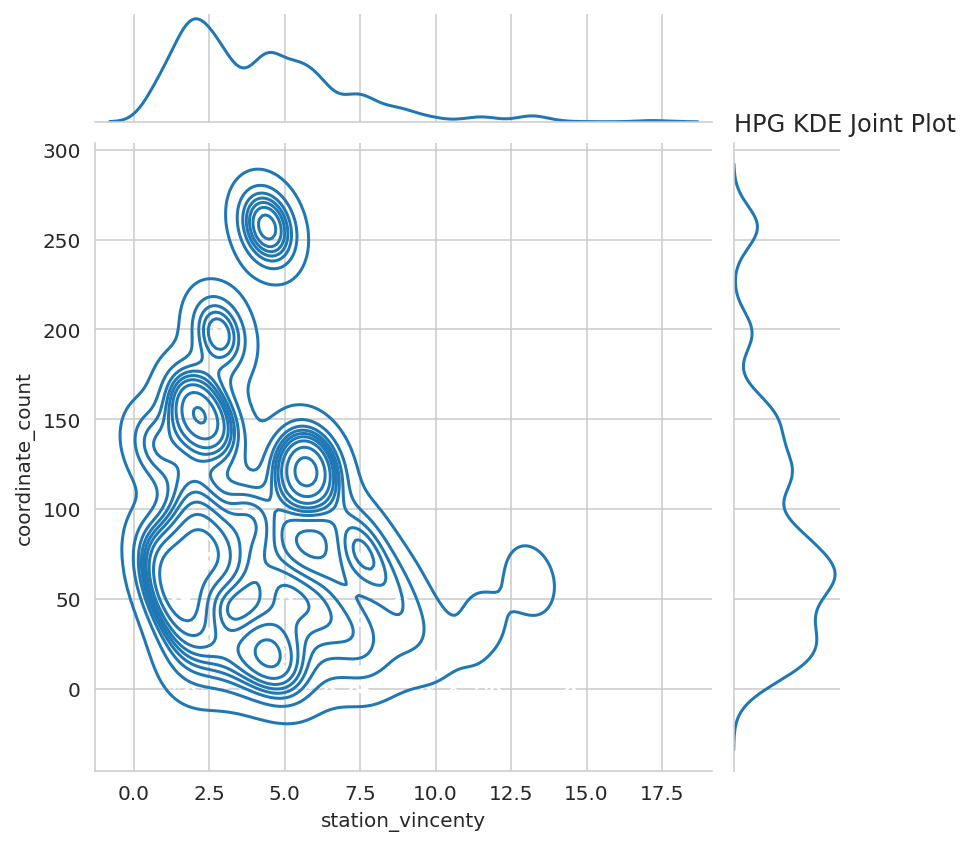

In [108]:
p = sns.jointplot(x='station_vincenty', y='coordinate_count', data=air_store_info, kind='kde')
plt.title('AIR KDE Joint Plot', loc='left')
p.plot_joint(plt.scatter, c='w', s=30, linewidth=1, marker='x')
plt.show()

p = sns.jointplot(x='station_vincenty', y='coordinate_count', data=hpg_store_info, kind='kde')
plt.title('HPG KDE Joint Plot', loc='left')
p.plot_joint(plt.scatter, c='w', s=30, linewidth=1, marker='x')
plt.show()

일본 상점 분포 (air,hpg)<div>
    <a href="https://plot.ly/~hmcgushion/4/?share_key=pArkblYSXlgzZWvBrvqeFH" target="_blank" title="AllStoresAndStations_Plot" style="display: block; text-align: center;"><img src="https://plot.ly/~hmcgushion/4.png?share_key=pArkblYSXlgzZWvBrvqeFH" alt="AllStoresAndStations_Plot" style="max-width: 100%;width: 1000px;"  width="1000" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="hmcgushion:4" sharekey-plotly="pArkblYSXlgzZWvBrvqeFH" src="https://plot.ly/embed.js" async></script>

- 출처: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=leita03&logNo=220967497386 (일본 도시 인구 2016년 기준)
- 출처: https://github.com/Pranathi30/Recruit-Restaurant-Visitor-Forecasting/blob/master/python%20project.ipynb (github)
- 출처: https://github.com/RobotPoly/exploration/blob/main/%5BE-6%5DHouse%20Price%20Prediction/%5BE-6%5D%20House%20Price%20Prediction.ipynb (github)
- 출처: https://www.hotpepper-gourmet.com/en/SS10/SA11/H000517610 (hpg 웹사이트)
- 출처 : https://airregi.jp/jp/function/?ref=airregi_navi (air_Regi 웹사이트)
- 출처: http://rstudio-pubs-static.s3.amazonaws.com/350598_82a23b7aa557414bb2cacfe2599b3461.html (참고)

 
- https://github.com/Pranathi30/Recruit-Restaurant-Visitor-Forecasting/blob/master/python%20project.ipynb (github참조)
- 참조했던 github에는 GridSearch 가 없었지만 추가하여 더 좋은 방안 모색하였음 그러나 github 작성자가 기존에 GridSearch,RandomSearch를 이용했는지 의도 파악을 하지 못하였음( 작성자는 한번에 하이퍼파라미터를 지정한거를 보면 search를 이용한거는 분명해 보이나 GridSearh를 이용한 것 같지는 않다고 생각이 됌)
- 기존에  앙상블 데이터를 기반으로 LGBMRegressor를 추가하여 여러 방안을 모색하였음.

- 최초 - 0.48525컬럼에 이것만 남겼을 때 - 0.48366
  ('DayofWeek', 'year', 'month', 'day_of_week', 'holiday_flg', 'air_genre_name', 'air_area_name',      'latitude','longitude''rs1_x', 'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'air_store_id2') 중간에 다른 방식으로 해본건 전부 최초 값보다 높게 나왔다. 
---------------------------

### 쇄빙선 탑승후기


- 김주현: 굉장히 많은 변수를 가진 레퍼런스를 이용해 호기롭게 항해를 시작하였음. 그러나 모델링 하기전 전처리 과정중 큰 빙산의 어려움을 겪어. 이후 5(목)요일 오후에 방향키를 돌려 처음부터 다시 진행하는 어려운 항해가 되었다. 그러나 산전수전을 겪은 우리 쇄빙호는 선원들과 캡틴의 합심으로 출발선을 달라도 경험의 추진력을 얻어 목적지 까지 안전하게 도달할 수 있었다. 개인적으로  단순한 전처리에 많은 힘을 쓰지 말고 먼저 밑그림을 모델링 쪽으로 돌려 전체적인 숲을 봐야 하는게 중요하다고 생각했습니다. 완벽하게 모델전 train,test 전처리 과정을 이해하지 못했지만 앞으로 어떻게 해야 하는지 감을 찾을 수 있는 기회였습니다.

------------
- 김유식: 처음 경험한 해커톤은 리드퍼실님이신 바롬님의 표현을 빌자면... 축제라고 하셨는데.. 축제와 공통점을 찾자면 해커톤이후로 바로 푹 쉬고 싶다는 생각이 드는점이었다. 제공되는 데이터 만으로도 상상력을 더해 아이디어를 제공하면 여러 데이터 결과값을 확인할수 있었다. 그리고 추가로 생기는 궁금증으로 이러이러한 데이터두 혹시 알수 있지 않을까? 하는 생각도 가질수 있엇다. 참고한 데이터들을 이해하는 과정도 힘들었고 그러면서 새롭게 알게된 내용두 많아서 좋은경험이었고 배울점도 많았다. 또한 왜 캐글대회 기간이 길수 밖에 없는 이유도 조금은 알것 같았다...



------------
- 서무일 :그래프로 자료들의 가시화를 하는 부분에서 대체 왜 필요한가? 라는 생각이 많이 드는 그래프를 굳이 그리는게 이해가 가지 않았다. 의외의 관련도를 찾고싶은 걸까, 아니면 작성자는 그게 중요하다는 것을 알고 있었기 때문에 굳이 그려본 것일까...특히 이해하기 어려웠던 부분은 예약시간과 방문시간의 차이에 대한 여러가지 계산값을 구하는 부분이었다. 대체 그게 왜 중요한걸까... 심지어 학습 데이터에도 그게 포함이 된다....또 하루동안 몇 시에 손님이 얼마나 있었는지도 그래프로 나타냈는데 그건 캐글의 목적과는 전혀 무관한 것으로 보여서 보기가 싫었다. 대체 내가 왜 이걸 이해하느라 시간을 쏟아야 하는 거지? 라는 생각이 들었기 때문...그런데 정말 정말 의아한 점은 예약 시간과 방문 시간의 차이가 반영되고 다른 여러 요소들 예를 들어 최소 방문객, 평균 방문객 등의 요소와 세분화한 음식점 유형(장르), 세분화한 지역 이름, 등등 학습에서 제외시켜버렸더니 점수가 낮아졌다. 즉 좋아졌다.... 심지어 원본 제작자가 올린 것을 그대로 출력했을 때보다 결과가 좋다! 대체 뭘까..... 원본의 작성자에게 쓸데없는 짓 한다고 마음속으로 욕한거 미안... 근데 위경도 괜히 나누고 더하고 그건 진짜 쓸데 없는거 같아...


----------

- 박경원: 우선 초반에 레퍼런스를 보지 않은 상태에 데이터를 어떻게 바라봐야 할지에 대한 고민과 활용에 대한 상상을 해보는 시간을 가지려고 했던 것 같다. 
  그 이후 레퍼런스를 보고 원작자의 의도를 알게 됨으로써 데이터 분석하기 위한 작성한 코드의 흐름이 보이기 시작했다. 캐글을 준비하면서 우선적으로 해야 할 것이 데이터를 거시적 관점으로 보며 어떻게 쪼개고 붙이고 틀어 볼지에 대한 생각을 해보는 것이 중요하다는 것을 알았다. 물론 빠를수록 좋다. 캐글은 문제를 자유롭게 가지고 놀며 만들고 싶은 걸 만들 수 있는 환경을 가졌다는 점에서 재미를 갖게 됐다. 같은 데이터도 누가 어떻게 보고 건드리고 분석하느냐에 따라 다른 결과를 도출할 수 있다.